In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 0. import data

In [2]:
# set random state
np.random.seed(42)

In [3]:
# load data
train = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/train_ready.csv')
test = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/test_ready.csv')

In [4]:
# drop price_per_m2 from train
train = train.drop(columns=['price_per_m2'])

In [5]:
# Custom dataset class
class PropertyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [6]:
# Neural Network model
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.view(-1, 1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                val_loss += criterion(y_pred, y_val.view(-1, 1)).item()
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

In [8]:
# prep data
def prepare_data(train_df):
    # Select numeric columns and target
    numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
    feature_cols = [col for col in numeric_cols if col not in ['price', 'property_id']]
    
    # Split features and target
    X = train_df[feature_cols].values
    y = train_df['price'].values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Scale target (log transform for price)
    y_log = np.log1p(y)
    
    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_log, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_dataset = PropertyDataset(X_train, y_train)
    val_dataset = PropertyDataset(X_val, y_val)
    
    return train_dataset, val_dataset, scaler, feature_cols

Using device: cpu
Epoch [5/50], Train Loss: 0.1851, Val Loss: 0.1606
Epoch [10/50], Train Loss: 0.1594, Val Loss: 0.1398
Epoch [15/50], Train Loss: 0.1497, Val Loss: 0.1362
Epoch [20/50], Train Loss: 0.1469, Val Loss: 0.1281
Epoch [25/50], Train Loss: 0.1411, Val Loss: 0.1171
Epoch [30/50], Train Loss: 0.1384, Val Loss: 0.1253
Epoch [35/50], Train Loss: 0.1352, Val Loss: 0.1337
Epoch [40/50], Train Loss: 0.1335, Val Loss: 0.1437
Epoch [45/50], Train Loss: 0.1322, Val Loss: 0.1485
Epoch [50/50], Train Loss: 0.1307, Val Loss: 0.1193


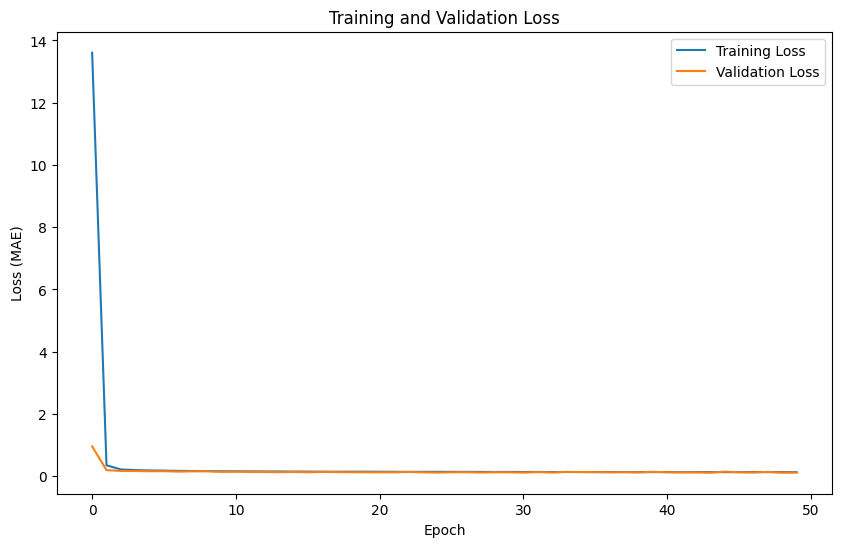

In [ ]:
# main training setup
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = PricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, device, num_epochs
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, feature_cols

# Usage
model, scaler, feature_cols = setup_and_train(train)

In [10]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v1.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v1.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  705795392
1  45550aa81c0151f1fd9fd8fe  686527296
2  735deef3382aa15930482f3e  717641984
3  0dd49fa8bb7be52b851c6dc9  722020416
4  7d3220a91e78f8bc2924d1cd  715632704


## V2 
--> doubled neurons on first layer

In [12]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            # Increased first layer from 128 to 256 neurons
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            # Rest of the architecture remains the same
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

Using device: cpu
Epoch [5/50], Train Loss: 0.1894, Val Loss: 0.1717
Epoch [10/50], Train Loss: 0.1551, Val Loss: 0.1389
Epoch [15/50], Train Loss: 0.1458, Val Loss: 0.1315
Epoch [20/50], Train Loss: 0.1449, Val Loss: 0.1262
Epoch [25/50], Train Loss: 0.1376, Val Loss: 0.1234
Epoch [30/50], Train Loss: 0.1332, Val Loss: 0.1319
Epoch [35/50], Train Loss: 0.1327, Val Loss: 0.1435
Epoch [40/50], Train Loss: 0.1295, Val Loss: 0.1156
Epoch [45/50], Train Loss: 0.1293, Val Loss: 0.1146
Epoch [50/50], Train Loss: 0.1280, Val Loss: 0.1393


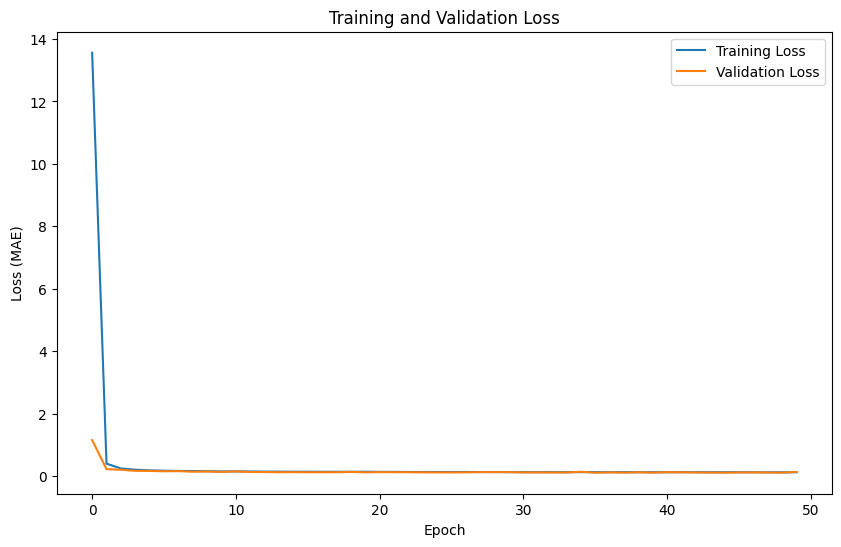

In [13]:
model, scaler, feature_cols = setup_and_train(train)

In [14]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v2.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v2.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  585912256
1  45550aa81c0151f1fd9fd8fe  584077952
2  735deef3382aa15930482f3e  632434432
3  0dd49fa8bb7be52b851c6dc9  618517440
4  7d3220a91e78f8bc2924d1cd  620445760


## v3 – LeakyReLU

In [ ]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),  
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

Using device: cpu
Epoch [5/50], Train Loss: 0.1900, Val Loss: 0.1701
Epoch [10/50], Train Loss: 0.1633, Val Loss: 0.1375
Epoch [15/50], Train Loss: 0.1509, Val Loss: 0.1344
Epoch [20/50], Train Loss: 0.1443, Val Loss: 0.1300
Epoch [25/50], Train Loss: 0.1423, Val Loss: 0.1311
Epoch [30/50], Train Loss: 0.1388, Val Loss: 0.1250
Epoch [35/50], Train Loss: 0.1384, Val Loss: 0.1349
Epoch [40/50], Train Loss: 0.1340, Val Loss: 0.1397
Epoch [45/50], Train Loss: 0.1332, Val Loss: 0.1325
Epoch [50/50], Train Loss: 0.1337, Val Loss: 0.1297


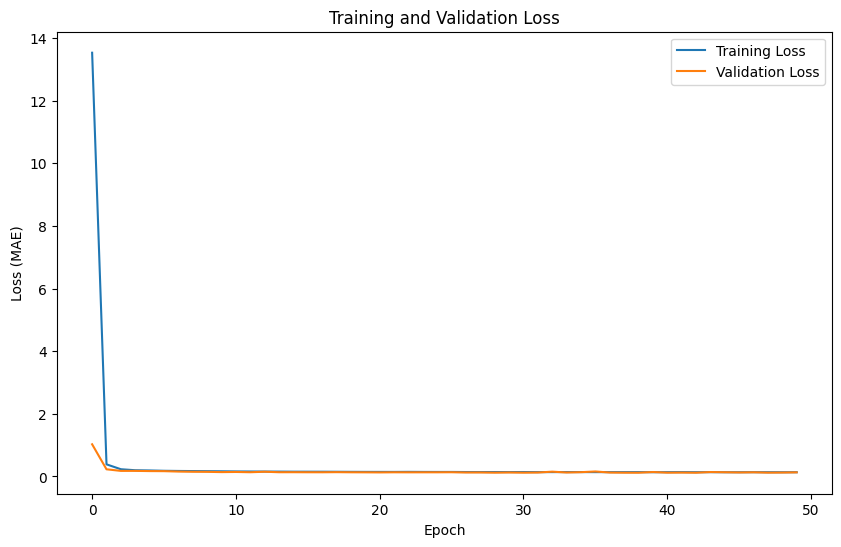

In [16]:
model, scaler, feature_cols = setup_and_train(train)

In [17]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v3.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v3.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  693523712
1  45550aa81c0151f1fd9fd8fe  606891008
2  735deef3382aa15930482f3e  731020544
3  0dd49fa8bb7be52b851c6dc9  729302016
4  7d3220a91e78f8bc2924d1cd  711028544


In [ ]:
# best-to-date

## v4 – residual connections

Residual connections allow the network to preserve and propagate subtle features more directly

In [18]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        # Initial projection to get to our desired width
        self.input_projection = nn.Linear(input_size, 128)
        
        # Main network layers
        self.layer1 = nn.Sequential(
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32)
        )
        
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        # Initial projection
        x = self.input_projection(x)
        
        # First residual block
        identity = x
        x = self.layer1(x)
        x = x + identity  # Residual connection
        
        # Rest of the network
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

Using device: cpu
Epoch [5/50], Train Loss: 0.1888, Val Loss: 0.1674
Epoch [10/50], Train Loss: 0.1655, Val Loss: 0.1495
Epoch [15/50], Train Loss: 0.1558, Val Loss: 0.1539
Epoch [20/50], Train Loss: 0.1465, Val Loss: 0.1389
Epoch [25/50], Train Loss: 0.1431, Val Loss: 0.1340
Epoch [30/50], Train Loss: 0.1378, Val Loss: 0.1224
Epoch [35/50], Train Loss: 0.1364, Val Loss: 0.1356
Epoch [40/50], Train Loss: 0.1351, Val Loss: 0.1249
Epoch [45/50], Train Loss: 0.1321, Val Loss: 0.1277
Epoch [50/50], Train Loss: 0.1326, Val Loss: 0.1218


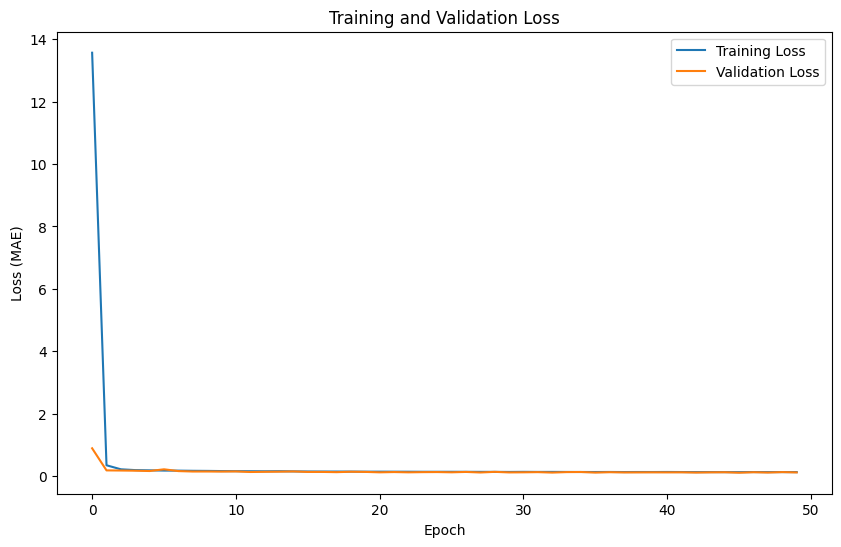

In [19]:
model, scaler, feature_cols = setup_and_train(train)

In [20]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v4.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v4.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  698835136
1  45550aa81c0151f1fd9fd8fe  635904704
2  735deef3382aa15930482f3e  712352064
3  0dd49fa8bb7be52b851c6dc9  716273152
4  7d3220a91e78f8bc2924d1cd  694524480


In [ ]:
## did not improve

### TODO
- [ ] Adjust the LeakyReLU slope (try 0.05 or 0.01)
- [ ] train for more epochs
- [ ] parallel paths w/ different activation f's
- [ ] adjust $\eta$ scheduler

### v5 – $\eta$ scheduler

In [22]:
# load v3 model (b2d)

class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),  
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)


In [23]:
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = PricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, device, num_epochs
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, feature_cols

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.view(-1, 1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                val_loss += criterion(y_pred, y_val.view(-1, 1)).item()
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        # Step the scheduler based on validation loss
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

Using device: cpu


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/50], Train Loss: 0.1856, Val Loss: 0.1549
Epoch [10/50], Train Loss: 0.1608, Val Loss: 0.1560
Epoch [15/50], Train Loss: 0.1529, Val Loss: 0.1374
Epoch [20/50], Train Loss: 0.1454, Val Loss: 0.1251
Epoch [25/50], Train Loss: 0.1426, Val Loss: 0.1295
Epoch [30/50], Train Loss: 0.1402, Val Loss: 0.1266
Epoch [35/50], Train Loss: 0.1338, Val Loss: 0.1180
Epoch [40/50], Train Loss: 0.1325, Val Loss: 0.1173
Epoch [45/50], Train Loss: 0.1302, Val Loss: 0.1214
Epoch [50/50], Train Loss: 0.1286, Val Loss: 0.1208


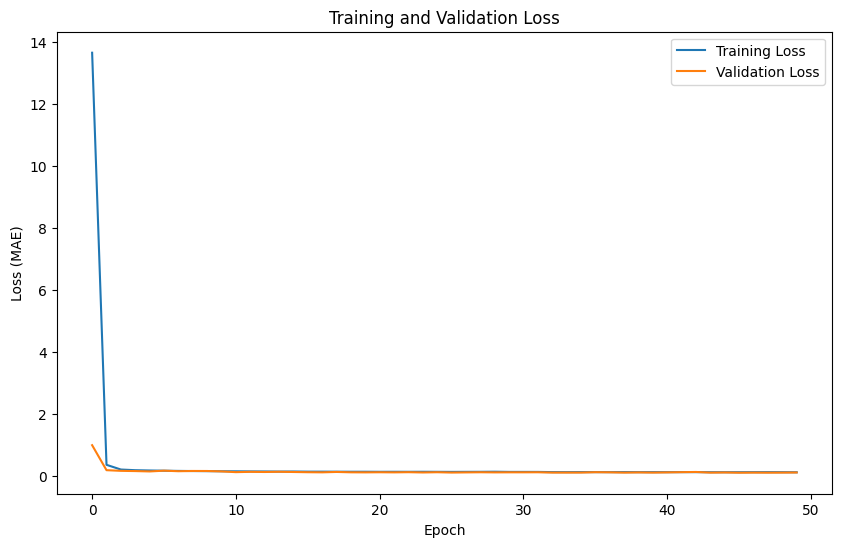

In [25]:
model, scaler, feature_cols = setup_and_train(train)

In [26]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v5.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v5.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  669358784
1  45550aa81c0151f1fd9fd8fe  640354560
2  735deef3382aa15930482f3e  685587712
3  0dd49fa8bb7be52b851c6dc9  708787584
4  7d3220a91e78f8bc2924d1cd  694675520


### TODO
- [ ] Adjust the LeakyReLU slope (try 0.05 or 0.01)
- [ ] train for more epochs
- [ ] parallel paths w/ different activation f's